In [1]:
from fastai.vision import *
from fastai.metrics import error_rate
from sklearn.model_selection import train_test_split
import numpy
import pandas as pd
import datetime

In [2]:
data_dir = Path("./data_dir")

In [3]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
#data = ImageDataBunch.from_csv(data_dir, folder='train', size=500, suffix='.jpeg', label_delim = ' ', ds_tfms=planet_tfms)

In [4]:
data = (ImageList.from_folder(data_dir) #Where to find the data? -> in path and its subfolders
        .split_by_folder()              #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .add_test_folder()              #Optionally add a test set (here default name is test)
        .transform(tfms, size=500)       #Data augmentation? -> use tfms with a size of 64
        .databunch(bs=4)
        .normalize(imagenet_stats))  

In [5]:
data.classes

['Gut', 'Mittel', 'Schlecht', 'Sehr_Gut']

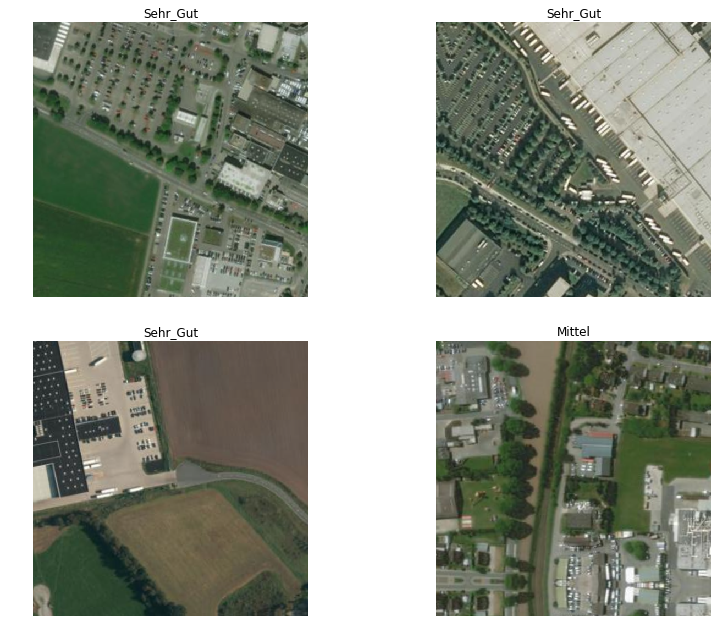

In [6]:
data.show_batch(rows=3, figsize=(12,9))

In [7]:
# set up convolutional neural network (cnn) based on pre-trained resnet50 architecture
# use accuracy as metric since we are doing classification tasks on single classes
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

In [8]:
# inspect network architecture
learn

Learner(data=ImageDataBunch;

Train: LabelList (89 items)
x: ImageList
Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500)
y: CategoryList
Sehr_Gut,Sehr_Gut,Sehr_Gut,Sehr_Gut,Sehr_Gut
Path: data_dir;

Valid: LabelList (23 items)
x: ImageList
Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500)
y: CategoryList
Sehr_Gut,Sehr_Gut,Sehr_Gut,Schlecht,Schlecht
Path: data_dir;

Test: LabelList (28 items)
x: ImageList
Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500)
y: EmptyLabelList
,,,,
Path: data_dir, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bo

In [9]:
learn.fit_one_cycle(4) # run one cycle for 4 epochs using our determined learning rate to adjust output layer to our own data

epoch,train_loss,valid_loss,accuracy,time
0,1.711863,1.123965,0.565217,00:11
1,1.629499,1.902609,0.260870,00:05
2,1.548729,1.692410,0.347826,00:05
3,1.420337,1.635904,0.304348,00:05


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


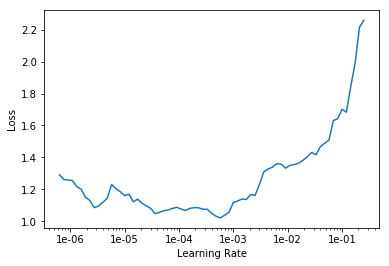

In [10]:
learn.unfreeze() # must be done before calling lr_find --> we can now train all layers, not just the last one
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(4, max_lr=slice(1e-5, 1e-3)) # fit model again, now adjusting all layers

epoch,train_loss,valid_loss,accuracy,time
0,0.999948,1.766698,0.260870,00:07
1,1.131492,1.577215,0.434783,00:07
2,1.162056,1.458568,0.304348,00:07
3,1.067649,1.498439,0.391304,00:07


In [12]:
train_val_size = str(len(learn.data.train_ds + learn.data.valid_ds))
learn.save("model_" + str(datetime.datetime.now()) + "_" + train_val_size + "items")

In [13]:
learn.export()

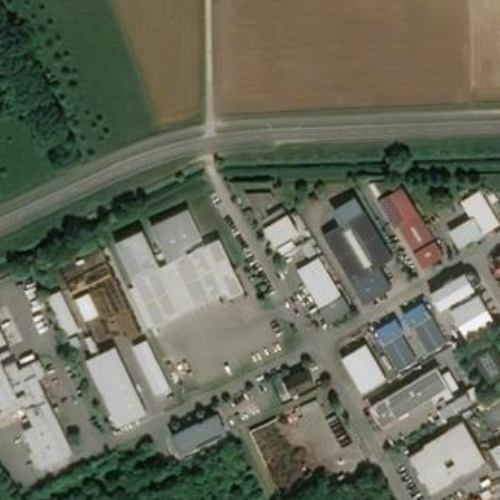

In [14]:
learn.data.test_ds[7][0]

In [44]:
prediction = learn.predict(learn.data.test_ds[7][0])

In [45]:
from torch import topk

In [46]:
prob, label = topk(prediction[2],4)

In [50]:
prediction[0]

Category Gut

In [52]:
# show mapping from labels to indices in our model
learn.data.c2i

{'Gut': 0, 'Mittel': 1, 'Schlecht': 2, 'Sehr_Gut': 3}

In [72]:
# reverse key/value pairs from "Gut": 0 to 0: "Gut" to later use in map function 
inv_map = {v: k for k, v in learn.data.c2i.items()}

In [80]:
labels = list(map(inv_map.get,label.data.tolist()))

In [81]:
dict(zip(labels, prob.data.tolist()))

{'Gut': 0.5485551357269287,
 'Sehr_Gut': 0.4023682773113251,
 'Mittel': 0.04478137195110321,
 'Schlecht': 0.004295220598578453}